# Charge Interactions in a Highly Charge-depleted Protein
<i>Stefan Hervø-Hansen</i><sup>a,b</sup>, <i>Casper Højgaard</i><sup>a</sup>, <i>Kristoffer Enøe Johansson</i><sup>a</sup>, <i>Yong Wang</i><sup>a</sup>, <i>Khadija Wahni</i><sup>c,d,e</sup>, <i>David Young</i><sup>c,d,e</sup>, <i>Joris Messens</i><sup>c,d,e</sup>, <i>Kaare Teilum</i><sup>a</sup>, <i>Kresten Lindorff-Larsen</i><sup>a,&#42;&#42;</sup>, and <i>Jakob Rahr Winther</i><sup>a,&#42;</sup>


a: Linderstrøm-Lang Centre of Protein Science, Department of Biology, University of Copenhagen, DK-2200 Copenhagen N, Denmark.<br>
b: Division of Theoretical Chemistry, Department of Chemistry, Lund University, SE 221 00 Lund, Sweden. <br>
c: VIB-VUB Center for Structural Biology, Vlaams Instituut voor Biotechnologie - Vrije Universiteit Brussel, B-1050 Brussels, Belgium.<br>
d: Brussels Center for Redox Biology, Vrije Universiteit Brussel, B-1050 Brussels, Belgium. <br>
e: Structural Biology Brussels, Vrije Universiteit Brussel, B-1050 Brussels, Belgium. <br>

&#42;To whom correspondence may be addressed jrwinther@bio.ku.dk <br>
&#42;&#42;Co-corresponding author, lindorff@bio.ku.dk <br>


This notebook contains the analysis of the results obtained from the constant pH molecular dynamics simulations.


## Import modules and convience functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import mdtraj as md
from scipy import stats, optimize
from adjustText import adjust_text
from IPython.display import Markdown
import uncertainties as unc

def pairwise(iterable):
    "s -> (s0, s1), (s2, s3), (s4, s5), ..."
    a = iter(iterable)
    return zip(a, a)

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Diprotic acid model: Salt bridge vs Hydrogen bond

<div style="padding: 0px; 
            width: auto; 
            word-wrap: break-word; 
            text-align:justify;">

<div style="width:image width px; 
            font-size:80%; 
            text-align:right; 
            float: right; padding-left-right-top-bottom:0.5em;">
    <img src="figures/Diprotic_acid_illustration.jpeg" 
         alt="Diprotic acid model" 
         width=300 
         style="padding-left:0.5em;"/>

</div>
To characterize the energetics of ion pairs in proteins, we have investigated the titration behaviour of an Asp-His pair in an otherwise charge depleted protein named EXG (PDB ID, <a href="https://www.rcsb.org/structure/6QFS" target="_blank">6QFS</a>) derived from a cellulose binding domain in <i>Cellulomonas fimi</i>. To do this we utilized a diprotic acid model (visualized) in which the diprotic acid can adapt 4 microstates consisting of the possible combinations of Asp and His being deprotonated and protonated. Within this scheme we can see that in the transition going from fully protoated to fully deprotoated, the two intermediate states are characterized by either being in a neutral state (PD) or zwitterionic state (DP). The population of these states has been measured using Monte Carlo simulations in the pH interval 2.0-9.5.
</div>

Due to only two titratable acids being present in the system, we can write a partition function which contains all information on the energics between the protonation states within the grand ensemble of protons
$$
\begin{equation}
\begin{aligned}
Z &= 1+ e^{-\beta \left( G_{01}^{0} - \mu_{ \mathrm{H}^{+}} \right)}\
+ e^{-\beta \left( G_{10}^{0} - \mu_{ \mathrm{H}^{+}} \right)}\
+ e^{-\beta \left( G_{11}^{0} - 2 \mu_{ \mathrm{H}^{+}} \right)} \\
  &= 1 + 10^{ \left( \mathrm{p}K_{10}^{00} -  \mathrm{pH} \right)} \
+ 10^{ \left( \mathrm{p}K_{01}^{00} -  \mathrm{pH} \right)} \
+ 10^{ \left( \mathrm{p}K_{11}^{10} + \mathrm{p}K_{10}^{00} - 2 \mathrm{pH} \right)}
\end{aligned}
\end{equation}
$$
The last equality is obtained due to the energy of protonating a group at a certain pH is given by $G_a = G_a^0 - \mu_{\text{H}^+} = - \beta^{-1} \ln 10 (\text{p}K_{\text{a}} - \text{pH})$. In the above expression we have choosen the ground state to be the fully deprotonated state, thus from the partition we can write an expression for the population of the individual states at any given pH value:
$$
\begin{equation}
\begin{aligned}
\left\langle \left( 00 \right) \right\rangle &= \frac{1}{Z} \\
\left\langle \left( 10 \right) \right\rangle &= \frac{10^{ \left( \mathrm{p}K_{10}^{00} -  \mathrm{pH} \right)}}{Z} \\
\left\langle \left( 01 \right) \right\rangle &= \frac{10^{ \left( \mathrm{p}K_{01}^{00} -  \mathrm{pH} \right)}}{Z} \\
\left\langle \left( 11 \right) \right\rangle &= \frac{10^{ \left( \mathrm{p}K_{11}^{10} + \mathrm{p}K_{10}^{00} - 2 \mathrm{pH} \right)}}{Z}
\end{aligned}
\end{equation}
$$
By fitting the four equations simultaniously under the constain of the thermodynamic cycle presented $(\mathrm{p}K_{01}^{11} + \mathrm{p}K_{01}^{00} = \mathrm{p}K_{11}^{10} + \mathrm{p}K_{10}^{00})$ we can obtain thermodynamic parameters which describe the entire system.

### Boltzmann Weights, Partition Function, & Minimization Function

In [144]:
# Boltzmann weight for each state and the partition function
def QPD(k):
    return 10**(k[0] - pH)
def QDP(k):
    return 10**(k[1] - pH)
def QPP(k):
    return 10**((k[0] + k[1] - k[2]) - 2*pH)
def QDD(k):
    return 1
def Z(k):
    return 1 + QPD(k) + QDP(k) + QPP(k)

# Minimization function
def target(k):
    minimization =  sum((1/Z(k) - DD)**2) + sum((QPD(k)/Z(k) - PD)**2) + sum((QDP(k)/Z(k) - DP)**2) + sum((QPP(k)/Z(k) - PP)**2)
    return minimization

# Write macroscopic function
def macroscopic(pH, pka1, pka2):
    return (10**(pka2 - pH) + 2 * 10**(pka1+pka2 - 2*pH)) / (1+10**(pka2 - pH) + 10**(pka1+pka2 - 2*pH))

### pKa Fitting and Bjerrum Diagram
We here fit the populations sampled by Monte Carlo simultions to the population expression derived from the Boltzmann distribution using both the microscopic cycle (previously shown) and though a macroscopic cycle, which is characterized by not distinguishing between proton locations, but only considers the net dissociation of protons.


    Microscopic              Macroscopic
       (2)            (PP)__
    DD ---- DP              \
(1) |       |  (3)          (1)           
    PD ---- PP                \__(DP+PD)__
       (4)                                 \
                                           (2)
                                             \__(DD)
Microscopic pKa values
----------------------
    1: 6.41 ± 0.05
    2: 6.66 ± 0.08
    3: 3.88 ± 0.08
    4: 4.13 ± 0.06
    Interaction energy W: 14.60 ± 0.76 kJ/mol
    
Macroscopic pKa values
----------------------
    1: 3.689 ± 0.072
    2: 6.855 ± 0.071



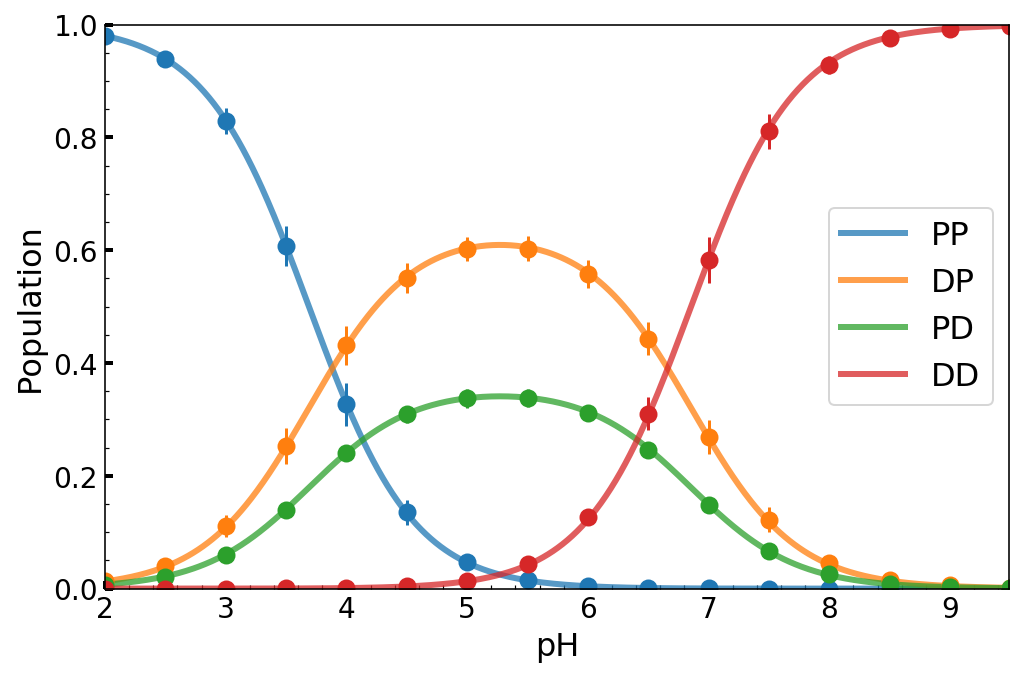

In [145]:
Nblocks = 4
states = np.zeros(shape=(Nblocks, len(pHs), 4)) # PD, PP, DP, DD

pHs = np.arange(2.00, 10.00, 0.5)

for i,pH in enumerate(pHs):
    titration = np.loadtxt('data/titration_data/39D66H/reordered_cpouts.pH_{:.2f}.dat'.format(pH), usecols=(3))
    statesPerBLock = len(titration)/(2*Nblocks)
    count = 0
    block = 0
    for Asp, His in pairwise(titration):
        if Asp > 0 and His > 0:     # PD
            states[block][i][0] += 1
        elif Asp > 0 and His == 0:  # PP
            states[block][i][1] += 1
        elif Asp == 0 and His == 0: # DP
            states[block][i][2] += 1
        elif Asp == 0 and His > 0:  # DD
            states[block][i][3] += 1
        else: # This condition should never happen
            raise Exception("State could not be catagorized")
        count += 1
        if count == statesPerBLock:
            block += 1
            count = 0
                       
states = states/statesPerBLock # Normalization


results_micro = np.empty(shape=(Nblocks, 6))
results_macro = np.empty(shape=(Nblocks, 2))

for i,block in enumerate(states):
    pH = pHs
    PD = block[:,0]
    PP = block[:,1]
    DP = block[:,2]
    DD = block[:,3]
    total = 1*PD + 2*PP + 1*DP + 0*DD
    micro = optimize.minimize(target, x0=np.array([7,4,6]), tol=10**(-7)).x
    macro = optimize.curve_fit(macroscopic, pH, total, p0=[3,6])[0]

    results_macro[i] = macro
    results_micro[i] = np.array([micro[0], micro[1], -micro[2]+micro[0],
                                 -micro[2]+micro[1], micro[2]*0.6*np.log(10)*4.18400, micro[2]])
    
arg_mean = results_micro.mean(axis=0)[0:5]
arg_std = results_micro.std(axis=0)[0:5]
print('''
    Microscopic              Macroscopic
       (2)            (PP)__
    DD ---- DP              \\
(1) |       |  (3)          (1)           
    PD ---- PP                \\__(DP+PD)__
       (4)                                 \\
                                           (2)
                                             \\__(DD)
Microscopic pKa values
----------------------
    1: {:4.2f} ± {:4.2f}
    2: {:4.2f} ± {:4.2f}
    3: {:4.2f} ± {:4.2f}
    4: {:4.2f} ± {:4.2f}
    Interaction energy W: {:4.2f} ± {:4.2f} kJ/mol
    
Macroscopic pKa values
----------------------
    1: {:4.3f} ± {:4.3f}
    2: {:4.3f} ± {:4.3f}
'''.format(arg_mean[0], arg_std[0], arg_mean[1], arg_std[1], arg_mean[2], arg_std[2], arg_mean[3], arg_std[3],
           arg_mean[4], arg_std[4], results_macro.mean(axis=0)[0], results_macro.std(axis=0)[0],
           results_macro.mean(axis=0)[1], results_macro.std(axis=0)[1]))


fig, ax = plt.subplots(figsize=(6*1.2, 4*1.2))

# Plot sampled data
pHs = np.arange(2.00, 10.00, 0.5)
plt.errorbar(pHs, states.mean(axis=0)[:,1], states.std(axis=0)[:,1], marker='o', markersize=8, linestyle='None', color='C0') # PP
plt.errorbar(pHs, states.mean(axis=0)[:,2], states.std(axis=0)[:,2], marker='o', markersize=8, linestyle='None', color='C1') # DP
plt.errorbar(pHs, states.mean(axis=0)[:,0], states.std(axis=0)[:,0], marker='o', markersize=8, linestyle='None', color='C2') # PD
plt.errorbar(pHs, states.mean(axis=0)[:,3], states.std(axis=0)[:,3], marker='o', markersize=8, linestyle='None', color='C3') # DD

# Plot fitted model
arg =  results_micro[:,[0,1,-1]].mean(axis=0) # arguments partition function.
pH = np.arange(min(pHs), max(pHs), 0.01)
ax.plot(pH, QPP(arg)/Z(arg), label='PP', linewidth=3, color='C0', alpha=0.75)
ax.plot(pH, QDP(arg)/Z(arg), label='DP', linewidth=3, color='C1', alpha=0.75)
ax.plot(pH, QPD(arg)/Z(arg), label='PD', linewidth=3, color='C2', alpha=0.75)
ax.plot(pH, QDD(arg)/Z(arg), label='DD', linewidth=3, color='C3', alpha=0.75)

# Graphical settings
ax.minorticks_on()
ax.set_ylim(0, 1)
ax.set_xlim(min(pH), max(pH))
ax.legend(loc=0, fontsize=16)
ax.set_xlabel('pH', fontsize=16)
ax.set_ylabel('Population', fontsize=16)
ax.tick_params(which='major', direction='in', length=4, width=2, colors='black',
               grid_color='black', grid_alpha=0.5, labelsize=14)
ax.tick_params(which='minor', direction='in')
fig.tight_layout()
#fig.savefig('figures/Diprotic_microstate_population.pdf', bbox_inches='tight')

From the Bjerrum diagram we find the zwitterionic state (DP) to be more populated than the neutral state (PD) for the Asp-His pair on the surface of the EXG protein.

## pH Depedent Conformational Exchange: Diprotic Acid
To gain futher insight into the strong interaction occuring for the D39-H66 pair, we continued by investigating the sampled conformation from the molecular dynamics simulations conducted in between the titration Monte Carlo moves. To do so, we choose to analyse the distance distribution between the side chain carboxylate group of D39 and the side chain pyrrole nitrogen ($\delta$) and pyridine nitrogen ($\epsilon$) of H66. Additionally, we analyzed if the movement was correlated by observing the first side chain dihedral angle $\chi_{1}$. These properties are suspected to be strongly pH depedent, so the analysis were conducted at pH 2.0, 5.0, and 9.0 corresponding to pHs where the different titration species are highly populated (see Bjerrum plot).

### pH-dependent Distance Distribution
To reduce the complexity of the points for the distance calculation between the Asp and His side chains we choose to use the midpoint between the two side chain carboxylate oxygen of D39 and the pyrrole nitrogen and pyridine nitrogen of H66, resulting in two distance distrubtion for each pH value.

In [ ]:
# pH values for which trajectories exists
pHs = [2, 5, 9]

# Initiate figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(1.5*5.5*1.2, 1.5*4*1.2))
axes = [item for sublist in axes for item in sublist]

for i, pH in enumerate(pHs):
    # Load trajecotry
    traj = md.load('trajectories/EXG_39D66H_pH{}.h5'.format(pH))
    
    coc_dN_dist = []
    coc_eN_dist = []
    
    # Getting index for the indivudal atoms
    asp_oxy = traj.topology.select('(resname AS4 and name OD1) || (resname AS4 and name OD2)') # Aspartate side chain carboxyl oxygen
    his_dN  = traj.topology.select('resname HIS and name ND1') # Histidine side chain pyrrole nitrogen
    his_eN  = traj.topology.select('resname HIS and name NE2') # Histidine side chain pyridine nitrogen
    
    for frame in range(traj.n_frames):
        # Calculate center of charge
        coc = (traj.xyz[frame][asp_oxy[0]] + traj.xyz[frame][asp_oxy[1]]) / 2
        
        # Append calculated distances to list
        coc_dN_dist.append(10*np.linalg.norm(coc - traj.xyz[frame][his_dN]))
        coc_eN_dist.append(10*np.linalg.norm(coc - traj.xyz[frame][his_eN]))
     
    for j, distance in enumerate([coc_dN_dist, coc_eN_dist]):
        # Create histogram and plot
        dist_probability, bin_edges_dist = np.histogram(distance, bins=100, density=True)
        bin_centers = (bin_edges_dist[:-1] + bin_edges_dist[1:]) / 2.
        
        if j == 0:
            label = '$\delta$'
        elif j == 1:
            label = '$\epsilon$'
        axes[i].plot(bin_centers, dist_probability, label=label)
        
    axes[i].set_xlim(1.7, 10.0)
    axes[i].set_ylim(0.0, 1.2)
    axes[i].minorticks_on()
    axes[i].set_title('pH {:.1f}'.format(pH), fontsize=18)
    axes[i].set_xlabel('Distance (Å)', fontsize=16)
    axes[i].set_ylabel('Probability density', fontsize=16)
    #axes[i].legend(loc='upper right', title='Histidine nitrogen', fontsize=14)
    axes[i].tick_params(which='major', direction='in', length=4, width=2, colors='black',
                   grid_color='black', grid_alpha=0.5, labelsize=14)
    axes[i].tick_params(which='minor', direction='in')

# Legend
leg = axes[1].legend(loc='upper left', title='Histidine nitrogen', fontsize=16, bbox_to_anchor=(1.0, 1.05))
for line in leg.get_lines():
    line.set_linewidth(6.0)
leg.get_title().set_fontsize(14)

# Image for 4. graph
#img = mpimg.imread('trajectories/Asp_His_pair_v4_2.png')
#imgplot = axes[3].imshow(img, interpolation='none')
axes[3].axis('off')

# Save figure
fig.tight_layout()
#fig.savefig('figures/Distance_distribution.png', dpi=600, bbox_inches='tight')

We can see a well-defined peak at pH 5.0 at approximately 2.8 Å between the centre of charge of the side chain carboxnyl oxygen of D39 and the pyridine nitrogen on the sidechain of H66, which is in good agreement with salt bridge and hydrogen bonding distances. This distinctive peak is absent at pH 2.0 and 9.0 which points towards the strong interaction is introduced in the zwitterionic and/or neutral state of the Asp-His pair. 
### pH-dependent Rotamer Distribution
We here deviate from the -180 to 180 convension for measurement of $\chi_{1}$ angles to instead using 0-360 in order to avoid the sampled states to lie in the boarders of the plot.

In [ ]:
# pH values for which trajectories exists
pHs = [2, 5, 9]

# Initiate figure
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

for i, pH in enumerate(pHs):
    # Load trajecotry
    traj = md.load('trajectories/EXG_39D66H_pH{}.h5'.format(pH))
    
    chi1_matrix = md.compute_chi1(traj, periodic=True, opt=True)
    chi1_Asp = np.asarray([np.rad2deg(chi1_matrix[1][i][26]) for i in range(traj.n_frames)]) # 26 is the index for Asp39
    chi1_His = np.asarray([np.rad2deg(chi1_matrix[1][i][49]) for i in range(traj.n_frames)]) # 49 is the index for His66
    chi1_Asp[chi1_Asp < 0] += 360
    chi1_His[chi1_His < 0] += 360
    
    mod_cmap = plt.cm.get_cmap('nipy_spectral_r')
    mod_cmap.set_bad('white')
    # histogram
    z, xedge, yedge = np.histogram2d(chi1_Asp, chi1_His, bins=50, density=True)
    x = 0.5*(xedge[:-1] + xedge[1:])
    y = 0.5*(yedge[:-1] + yedge[1:])
    z[z == 0] = np.nan
    extent = [yedge[0], yedge[-1], xedge[0], xedge[-1]]
    
    axes[i].contourf(x, y, z.T, 50, extent=extent, cmap=mod_cmap)
    #axes[i].hist2d(chi1_Asp, chi1_His, bins=(50,50), range=((0,360),(0,360)), density=True, cmap='nipy_spectral')
    print('Progress: pH {pH} finished!'.format(pH=pH))
    
for i, ax in enumerate(axes):
    ax.set_xlim(0, 361)
    ax.set_ylim(0, 361)
    ax.set_title('pH {:.1f}'.format(pHs[i]), fontsize=20)
    ax.set_xlabel('D39 χ₁ (degrees)', fontsize=16)
    ax.set_ylabel('H66 χ₁ (degrees)', fontsize=16)
    ax.tick_params(which='major', direction='in', length=4, width=2, colors='black',
                   grid_color='black', grid_alpha=0.5, labelsize=14)
    ax.tick_params(which='minor', direction='in')

fig.tight_layout()
#fig.savefig('figures/D39H66_sidechain_dihedral.pdf', bbox_inches='tight')

Examining the joint distribution of $\chi_{1}$ angles of D39 and H66 we find at pH 2.0 and 9.0 D39 was mostly found with $\chi_{1}$ in the <i>p</i>-rotamer ($\chi_{1}$~60°), whereas at pH 5.0 it mostly sampled the <i>t</i>-rotamer ($\chi_{1}$ ~180°). The histidine was mostly found in the <i>t</i>-rotamer, sampling also the <i>m</i>-rotamer ($\chi_{1}$ ~300°) at low pH. When D39 was in the p-rotamer, the aspartate side chain faced the solvent, whereas the <i>t</i>-rotamer state populated at pH 5.0 corresponded to the conformation from the short-distance peak at pH 5 in Figure 4, with the aspartate side chain facing the side chain of H66.

## pH Depedent Conformational Exchange: Monoprotic Single-aspartate Residues
### pH Dependent Rotamer Distribution

In [ ]:
pHs = [0.5, 8.0] # pH values for which trajectories exists
variants = ['39D', '43D', '61D'] # aspartate variants
var_indexes = [26, 30, 46] # index for variants list

# Initiate figure
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

for i, variant in enumerate(variants):
    j = 0
    for pH in pHs:
        # Load trajecotry
        traj = md.load('trajectories/EXG_{variant}_pH{pH}.h5'.format(variant=variant, pH=pH))
        
        chi1_matrix = md.compute_chi1(traj, periodic=True, opt=True)
        chi1_Asp = np.asarray([np.rad2deg(chi1_matrix[1][j][var_indexes[i]]) for j in range(traj.n_frames)])
        chi1_Asp[chi1_Asp < 0] += 360
        
        probabilities, edges = np.histogram(chi1_Asp, bins=60, density=True)
        centers = 0.5*(edges[1:]+ edges[:-1])
        axes[i].plot(centers, probabilities, color='C{}'.format(j), linewidth=3)
        print('Progress: Variant {variant}, pH {pH} finished!'.format(variant=variant, pH=pH))
        j+=1
        
for i, ax in enumerate(axes):
    ax.set_xlim(0, 360)
    ax.set_ylim(0, 0.04)
    ax.set_title('{}'.format(variants[i]), fontsize=20)
    ax.set_xlabel('χ₁ (degrees)', fontsize=16)
    ax.set_ylabel('Probability density', fontsize=16)
    ax.tick_params(which='major', direction='in', length=4, width=2, colors='black',
                   grid_color='black', grid_alpha=0.5, labelsize=14)
    ax.tick_params(which='minor', direction='in')

fig.tight_layout()
#fig.savefig('figures/Asp_sidechain_dihedral.pdf', bbox_inches='tight')

## Titration Curves of EXG Variants: pK<sub>a</sub> Values & Hill Coefficients

The Henderson–Hasselbalch equation is given by
$$
\text{pH} = \text{p}K_{a} + \log{\left(\frac{[\text{B}]}{[\text{A}]}\right)},
$$
where $[\text{A}]$ and $[\text{B}]$ is the concentration of acid and base respectively. We define the acid fraction (the protonated fraction), $y_a$, and base fraction (the deprotonated fraction), $y_b$, as
$$
y_a = \frac{[\text{A}]}{[\text{A}]+[\text{B}]}, \quad y_b=\frac{[\text{B}]}{[\text{B}]+[\text{A}]}, \quad y_a + y_b = 1.
$$
<div style="padding: 0px; 
            width: auto; 
            word-wrap: break-word; 
            text-align:justify;">

<div style="width:image width px; 
            font-size:80%; 
            text-align:right; 
            float: right; padding-left-right-top-bottom:0.5em;">
    <img src="figures/hillIllustration.png" 
         alt="Hill coeffificent in titrations" 
         width=300 
         style="padding-left:0.5em;"/>

</div>
Rewriting the Henderson–Hasselbalch equation in terms of the base fraction we obtain
$$
\text{pH} = \text{p}K_{a} + \log{\left(\frac{y_b}{1-y_b}\right)} \implies y_b = \frac{1}{1+10^{\text{p}K_{a}-\text{pH}}}.
$$
To capture deviation in titration behavour due to ultrasensitivity, which is related to the steepness of the transition, we introduce the Hill coefficient ($n$) into the equation above
$$
y_b = \frac{1}{1+10^{n \left(\text{p}K_{a}-\text{pH}\right)}}
$$
The above equation will serve as fitting equation to obtain $\text{p}K_{a}$ values from single residue titration curves.
</div>

In [ ]:
# Hill modified Henderson–Hasselbalch equation expressed for the deprotonated fraction
def DeprotFraction(pH, pka, n):
    return 1/(1+10**(n*(pka - pH)))

# Initiate figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

Table = [] # Empty list used to append table values
variants = ['39D', '43D', '61D', '39D66H', '43D66H', '61D66H'] # EXG variants
for i, variant in enumerate(variants):
    numTitrationSites = sum(c.isalpha() for c in variant)
    data = np.loadtxt('data/titration_curves_{}.dat'.format(variant), usecols=(range(numTitrationSites + 1)),
                      skiprows=1, unpack=False)
    pH = data[:,0]
    for j, resid in enumerate(range(1, numTitrationSites + 1)):
        axes[j].plot(pH, data[:,resid], markersize=8, linestyle='None', marker='o', color='C{}'.format(i))
        
        # Conditions for table & fitting of titration data.
        if j == 0:
            Table.append(variant)
        if variant == '39D66H':  # Do not plot single titration curve for `39D66H` variant.
            continue
        if resid == 1:
            p0 = 3 # Initial guess for Aspratate
        else:
            p0 = 6 # Initial guess for Histidine
            
        popt, pcov = optimize.curve_fit(DeprotFraction, pH, data[:,resid], p0=[1,p0])
        perr = np.sqrt(np.diag(pcov))
        axes[j].plot(pH, DeprotFraction(pH,*popt), linewidth=3, alpha=0.75, color='C{}'.format(i))
        
        Table.extend(['{:.3f} ± {:.3f}'.format(popt[0], perr[0]), '{:.3f} ± {:.3f}'.format(popt[1], perr[1])])

# Beautification
for i, ax in enumerate(axes):
    ax.minorticks_on()
    ax.set_xlabel('pH', fontsize=16)
    ax.set_ylabel('Degree of proton dissociation', fontsize=16)
    ax.tick_params(which='major', direction='in', length=4, width=2, colors='black',
               grid_color='black', grid_alpha=0.5, labelsize=14)
    ax.tick_params(which='minor', direction='in')

axes[0].set_title('Aspratate', fontsize=20)
axes[1].set_title('Histidine', fontsize=20)

fig.tight_layout()
#fig.savefig('figures/singleResidueTitrationCurves.pdf', bbox_inches='tight')

Markdown('''
| Variant | pKa (Asp) | n (Asp) | pKa (His) | n (His) |
|---------|-----------|---------|-----------|---------|
|  {}     |   {}      | {}      |     -     |    -    |
|  {}     |   {}      | {}      |     -     |    -    |
|  {}     |   {}      | {}      |     -     |    -    |
|  {}     |    -      |   -     |     -     |    -    |
|  {}     |   {}      | {}      |   {}      |  {}     |
|  {}     |   {}      | {}      |   {}      |  {}     |
'''.format(*Table))

## pKa Prediction of Titratable Residues in a Highly Charge-depleated Protein
Total correlation plot between predicted pKa values by CpHMD simulation and experimental pKa values by NMR spectroscopy for the EXG system.

In [ ]:
#### EXG DATA ####

# Experimental pka values
Asp39  = 5
Asp43  = 4.37
Asp61  = 4.15
Asp39d = 4.07
Asp43d = 4.32
Asp61d = 4.1

His66  = 6.39
His66d39 = 7.24
His66d43 = 6.49 
His66d61 = 6.68

exp_asp = [Asp39, Asp43, Asp61, Asp39d, Asp43d, Asp61d]
exp_his = [His66, His66d39, His66d43, His66d61]

# Predicted pka values
sim_Asp39 = 5.33
sim_Asp43 = 4.78
sim_Asp61 = 4.49
sim_Asp39d= 3.69
sim_Asp43d= 4.66
sim_Asp61d= 4.19

sim_His66 = 6.1
sim_His66d39 = 6.85
sim_His66d43 = 6.01
sim_His66d61 = 6.07

sim_asp = [sim_Asp39, sim_Asp43, sim_Asp61, sim_Asp39d, sim_Asp43d, sim_Asp61d]
sim_his = [sim_His66, sim_His66d39, sim_His66d43, sim_His66d61]


label_asp = ['D39', 'D43', 'D61', 'H66-D39', 'H66-D43', 'H66-D61']
label_his = ['H66', 'H66-D39', 'H66-D43', 'H66-D61']

In [ ]:
# Begin figure
fig = plt.figure()
ax = fig.add_axes([0.0, 0.0, 1.0, 1.0])

texts = []

# Plot
ax.scatter(sim_asp, exp_asp, color='red', label='Asp')
ax.scatter(sim_his, exp_his, color='blue', label='His')

for i, txt in enumerate(label_asp):
    if i > 2:
        weight = 'normal'
    else:
        weight = 'normal'
    text = ax.annotate(txt, (sim_asp[i], exp_asp[i]), weight=weight,
                       bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.1'))
    texts.append(text)
    
for i, txt in enumerate(label_his):
    text = ax.annotate(txt, (sim_his[i], exp_his[i]),
                       bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.1'))
    texts.append(text)


# Statistics and Regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(sim_asp+sim_his,exp_asp+exp_his)
f = lambda x: slope*x + intercept
g = lambda x: x
x = np.array([3.5,10])
#ax.plot(x, f(x), label='Linear fit')
ax.plot(x, g(x), color='black', alpha=0.5)
ax.plot(x, g(x)+0.39, color='gray', alpha=0.5, linestyle='dashed')
ax.plot(x, g(x)-0.39, color='gray', alpha=0.5, linestyle='dashed')

# Axis modification
ax.set_xlim(3.5,7.5)
ax.set_ylim(3.5,7.5)
ax.minorticks_on()
ax.legend(loc=0, fontsize=14, frameon=False)
ax.set_xlabel(r'p$K_{\mathrm{a}}$ Simulation', fontsize=16)
ax.set_ylabel(r'p$K_{\mathrm{a}}$ Experiment', fontsize=16)

ax.set_xticks(np.arange(3.5, 8.0, 0.5))
ax.tick_params(which='major', direction='in', length=4, width=2, colors='black',
               grid_color='black', grid_alpha=0.5, labelsize=14)
ax.tick_params(which='minor', direction='in')
ax.set_aspect('equal')

fig.tight_layout()
# Avoid overlapping annotations
adjust_text(texts, expand_points=(2.0,2.0), expand_text=(2.0, 2.0), expand_align=(2.2, 2.2),
            arrowprops=dict(arrowstyle='->', color='black')) # 1.3,1.3
#fig.savefig('figures/Total_pka_correlation.pdf', bbox_inches='tight')

print('slope: {}'.format(slope))
print('intercept: {}'.format(intercept))
print('r_value**2: {}'.format(r_value**2))

sim_full = np.append(sim_asp, sim_his)
exp_full = np.append(exp_asp, exp_his)

pKa_RMSD = np.sqrt(np.sum(np.subtract(sim_full,exp_full)**2)/len(exp_full))
print(r'Root-mean-square error (RMSE) of pKa values: {}'.format(pKa_RMSD))